In [1]:
import os
import logging
from pathlib import Path
import datetime
import xml.etree.ElementTree as ET

from tqdm import tqdm
import numpy as np
import math
import pandas as pd
import random

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
# Not needed
# from torchvision.transforms import ToTensor 
# from torchvision.transforms.v2 import (Compose, ToImage, ToDtype, 
#                                        Normalize, RandomPhotometricDistort)

import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt

import torch.nn as nn 
from torch.nn.utils import parameters_to_vector
import torch.optim as optim

import torchmetrics

import cv2

In [2]:
#torch.cuda.empty_cache()

# Logger

In [3]:
log_path = 'results_v4/'

logger = logging.getLogger("GonLogger")
logger.propagate = False
logger.setLevel(logging.INFO)
file_handler = logging.FileHandler(log_path + 'logfile.log')
formatter = logging.Formatter('%(message)s')
file_handler.setFormatter(formatter)

# add file handler to logger
logger.addHandler(file_handler)

logger.info('BED Classifier XS Tiny. Trying to reduce it: v1. 255 Normalization. Weighted for Precision.')

# Config

In [4]:
CLASSES = ["smoke", "fire"]
N_CLASSES = len(CLASSES)

IMG_DIM = {'W':224, 'H':224} # (W, H)
IMG_H = IMG_DIM['H']
IMG_W = IMG_DIM['W']

# Dataset

# DFire

In [5]:
class DFireDataset(Dataset):
    '''
    Creates a Pytorch Dataset to train the Yolov1 Network.
    Encodes labels to match the format [xcell, ycell, w, h, confidence, class_0 (smoke), class_1 (fire)]
        - Final encoding format is: [xcell, ycell, w, h, conf=1, smoke?, fire?]

    Discard images when there are more than 1 object in the same cell
    
    Arguments:
        - img_h:            image height
        - img_w:            image width
        - img_dir:          path to images folder
        - label_dir:        path to labels folder
        - num_classes:      number of classes
        - transform:        transformation applied to input images -> Albumentations
        - target_transform: transformation applied to labels -> nothing by default

    Return:
        - img:              1 image of the dataset
        - target:           corresponding label encoded: [smoke, fire]
    '''

    def __init__(self, img_h, img_w, img_dir, label_dir, num_classes,
                 ds_len,
                 transform=None, target_transform=None):
        self.img_h = img_h
        self.img_w = img_w
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.num_classes = num_classes
        self.ds_len = ds_len
        self.transform = transform
        self.target_transform = target_transform
        
        self.except_transform = A.Compose([
                                    A.Resize(self.img_h, self.img_w, p=1),
                                    #A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1), 
                                    ToTensorV2(p=1),
                                    ]
                                )

        self.labels_list = sorted(
            [
                os.path.join(self.label_dir, file_name)
                for file_name in os.listdir(self.label_dir)
                if file_name.endswith(".txt")
            ]
        )
    
        if ds_len is not None:
            random.seed(123)
            random.shuffle(self.labels_list)
            self.images_path, self.labels = self.__build_ds__(self.labels_list[:self.ds_len])
            self.num_samples = len(self.labels_list[:self.ds_len])
        else:
            self.images_path, self.labels = self.__build_ds__(self.labels_list)
            self.num_samples = len(self.labels_list)

    def __len__(self):
        return self.num_samples   

    def __build_ds__(self, labels_list):
        labels = []
        images = []
        wrong_imgs = 0
        empty = 0
        only_smoke = 0
        only_fire = 0
        smoke_fire = 0
                
        for label in labels_list:
            fname = Path(label).stem
            image_path = self.img_dir + fname + '.jpg'   
            #print(fname, image_path)
                                   
            if cv2.imread(image_path) is None:
                print(f'{image_path} cannot be read by cv2 -> removed')
                wrong_imgs += 1
            
            else:
                
                label_array = np.zeros((self.num_classes))
            
                with open(label) as f:
                    lines = f.readlines()
                       
                    for line in lines:
                        class_id, _, _, _, _ = line.strip().split()
                        class_id = int(class_id)
                        if np.array_equal(label_array, np.array([1, 1])):
                            break
                        else:
                            label_array[class_id] = 1.

                    if np.array_equal(label_array, np.array([1, 1])):
                        smoke_fire += 1
                    elif np.array_equal(label_array, np.array([0, 1])):
                        only_fire += 1
                    elif np.array_equal(label_array, np.array([1, 0])):
                        only_smoke += 1
                    elif np.array_equal(label_array, np.array([0, 0])):
                        empty += 1
                    else:
                        print("Wrong label in DFire dataset")
                        logger.info("Wrong label in DFire dataset")
                        
                    labels.append(label_array)
                    images.append(image_path)
        
        print(f'DFire Removed wrong images: {wrong_imgs}')
        logger.info(f'DFire Removed wrong images: {wrong_imgs}')
        print(f'DFire empty images: {empty}')
        logger.info(f'DFire empty images: {empty}')
        print(f'DFire only smoke images: {only_smoke}')
        logger.info(f'DFire only smoke images: {only_smoke}')
        print(f'DFire only fire images: {only_fire}')
        logger.info(f'DFire only fire images: {only_fire}')
        print(f'DFire smoke and fire images: {smoke_fire}')
        logger.info(f'DFire smoke and fire images: {smoke_fire}')

        labels_np = np.array(labels)
        labels_tensor = torch.tensor(labels_np, dtype=torch.float32)
        images_array = np.array(images)
        
        return images_array, labels_tensor

    def __getitem__(self, index):

        # Image processing
        img_file = self.images_path[index]
        img = cv2.imread(img_file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)   

        # Labels processing
        label = self.labels[index]
        
        # Data Augmentation
        if self.transform is not None:
            try:
                aug = self.transform(image=img)
                img = aug['image'] / 255.0
            except:
                #print(f'Error trying to augment image {img_file}')
                aug = self.except_transform(image=img)
                img = aug['image'] / 255.0
        
        return img, label

### View Dataset

In [6]:
ds_dir = '../../../datasets/ds2fire/dfire_yolo/'

train_dir = ds_dir + 'train/'
train_imgs = train_dir + 'images/'
train_labels = train_dir + 'labels/'

#val_dir = ds_dir + 'test/'

val_dir = ds_dir + 'test/'
val_imgs = val_dir + 'images/'
val_labels = val_dir + 'labels/'

print(f'Train dir: {os.listdir(train_dir)}')
print(f'val dir: {os.listdir(val_dir)}')

Train dir: ['labels', '.ipynb_checkpoints', 'images']
val dir: ['labels', '.ipynb_checkpoints', 'images']


### Transform

In [7]:
view_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.OneOf([
            A.RandomBrightnessContrast(p=0.4),
            A.HueSaturationValue(hue_shift_limit=10, p=0.2),
            A.Blur(blur_limit=(3,3), p=0.3),
            A.CLAHE(clip_limit=2.0, p=0.3),
            A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        ], p=0.9),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.Resize(IMG_H, IMG_W, p=1),
        ToTensorV2(p=1),
    ]
)

In [8]:
VIEW_BATCH_SIZE = 32

view_dfire_ds = DFireDataset(img_h=IMG_H, 
                             img_w=IMG_W, 
                             img_dir=val_imgs, 
                             label_dir=val_labels, 
                             num_classes=N_CLASSES,
                             ds_len=2*VIEW_BATCH_SIZE,
                             transform=view_transform)

view_loader = DataLoader(dataset=view_dfire_ds,
                         batch_size=VIEW_BATCH_SIZE,
                         num_workers=1,
                         pin_memory=True,
                         shuffle=True,
                         drop_last=False)
print(f'Val dataset length: {len(view_dfire_ds)}')

DFire Removed wrong images: 0
DFire empty images: 31
DFire only smoke images: 17
DFire only fire images: 2
DFire smoke and fire images: 14
Val dataset length: 64


# Plot Dataset Pictures

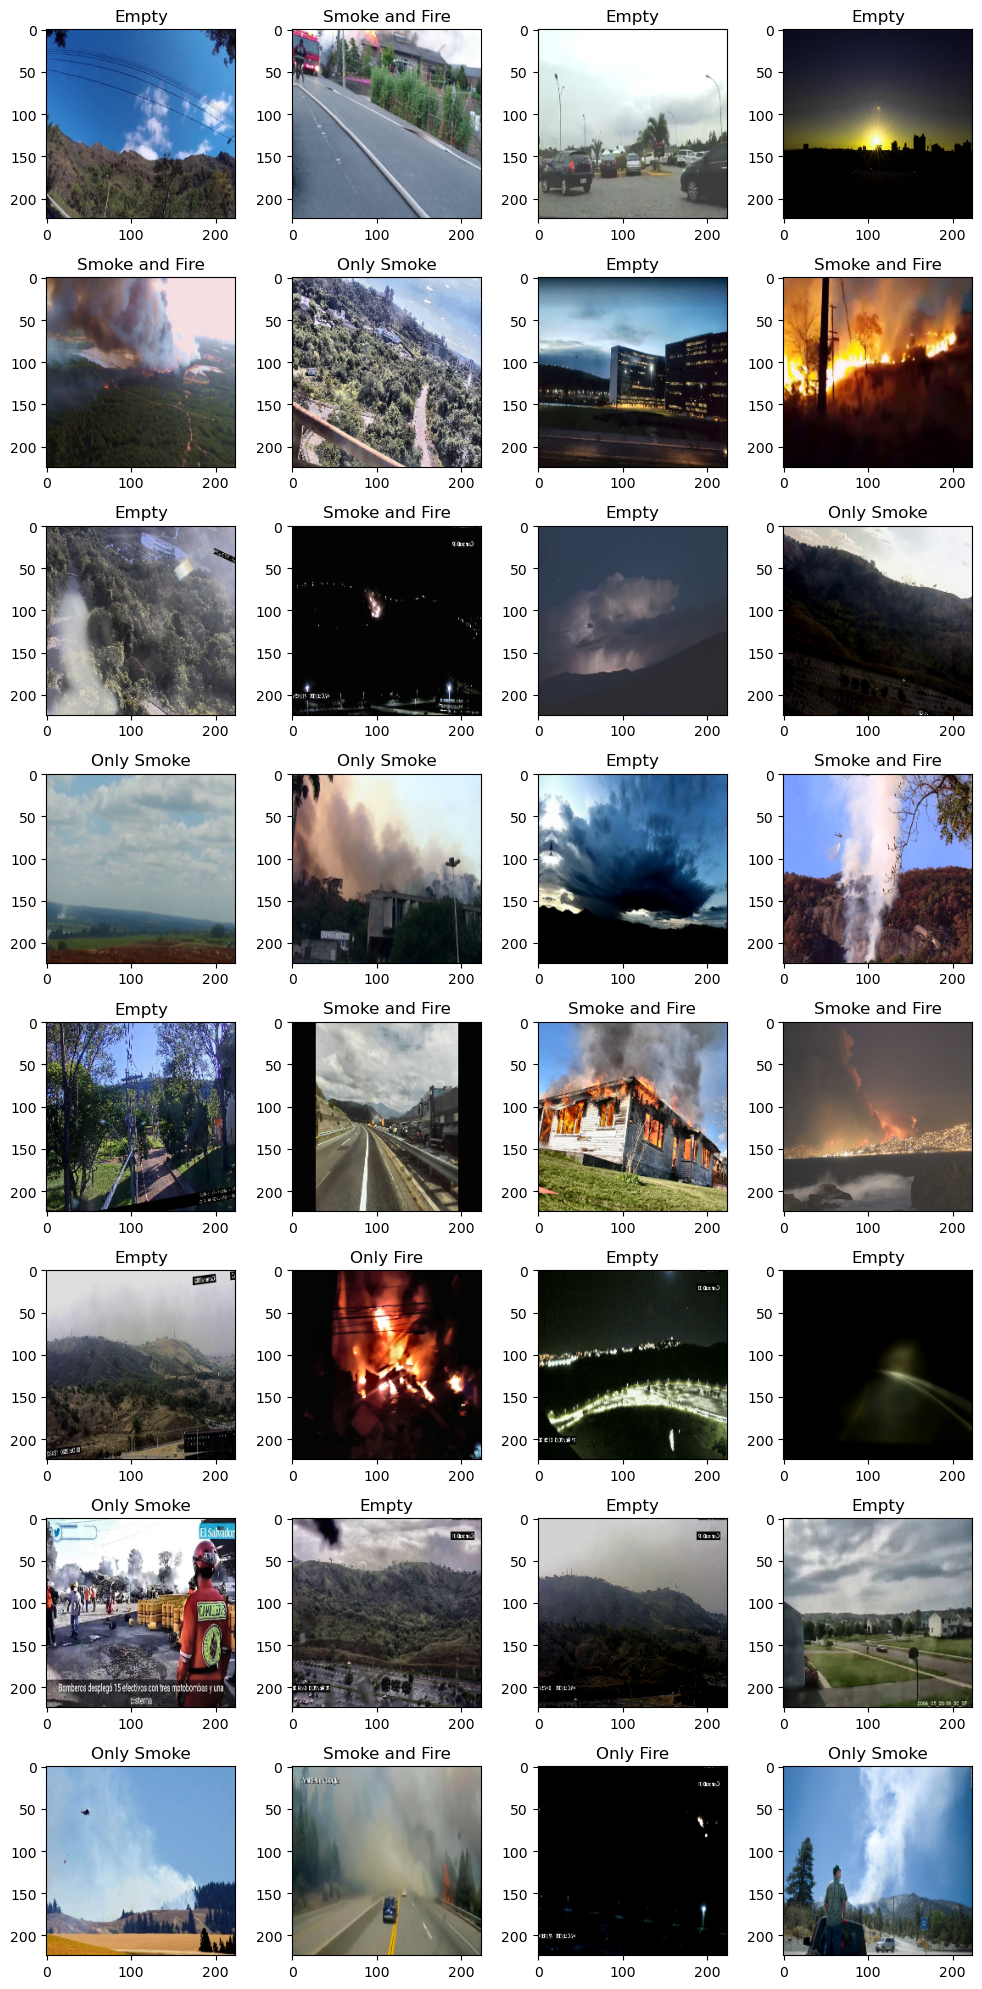

In [9]:
for i, (img, label) in enumerate(view_loader):

    plt.subplots(8,4, figsize=(10, 20))
    
    for idx in range(VIEW_BATCH_SIZE):
        plt.subplot(8, 4, idx+1)
        plt.imshow(img[idx].permute(1, 2, 0))
        title = ""
        if label[idx][0] == 1 and label[idx][1] == 1:
            title += "Smoke and Fire"
        elif label[idx][0] == 1 and label[idx][1] == 0:
            title += "Only Smoke"
        elif label[idx][0] == 0 and label[idx][1] == 1:
            title += "Only Fire"
        else:
            title += "Empty"
        plt.title(title)
        
        if (idx == 31):
            break
    plt.tight_layout()
    plt.show()
    break

# Model: BED Less Layers

In [10]:
class BED_CLASSIFIER(nn.Module):
    def __init__(self, num_classes, in_channels=3):
        super(BED_CLASSIFIER, self).__init__()
        self.in_channels = in_channels
        self.last_channels = 64
        self.num_classes = num_classes
        
        self.model = self.__create_BED__()
        
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.smoke = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=self.last_channels, out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16, out_features=1)
        )
        self.fire = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=self.last_channels, out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16, out_features=1)
        )

        
    def __create_BED__(self):
        BED_model = nn.Sequential(
            # Conv2d [in_channels, out_channels, kernel_size, stride, padding, bias]

            # CNNBlock 224x224
            nn.Conv2d(self.in_channels, 32, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            nn.Dropout2d(p=0.3),

            # CNNBlock 112x112
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(16, affine=False),
            nn.ReLU(),
            nn.Dropout2d(p=0.3),

            # CNNBlock 56x56
            nn.MaxPool2d(kernel_size=2, stride=2),
            # kernel = 1 in github
            nn.Conv2d(16, 16, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(16, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            # kernel = 1 in github
            nn.Conv2d(32, 32, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),

            # CNNBlock 28x28
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),

            # CNNBlock 14x14
#             nn.MaxPool2d(kernel_size=2, stride=2), 
#             nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0,  bias=False),
#             nn.BatchNorm2d(32, affine=False),
#             nn.ReLU(),
            
#             nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
#             nn.BatchNorm2d(64, affine=False),
#             nn.ReLU(),
            
#             nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0,  bias=False),
#             nn.BatchNorm2d(32, affine=False),
#             nn.ReLU(),
            
#             nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
#             nn.BatchNorm2d(64, affine=False),
#             nn.ReLU(),
            
#             nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1,  bias=False),
#             nn.BatchNorm2d(64, affine=False),
#             nn.ReLU(),
            
#             nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1,  bias=False),
#             nn.BatchNorm2d(64, affine=False),
#             nn.ReLU(),
            
#             # CNNBlock 7x7
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1,  bias=False),
#             nn.BatchNorm2d(128, affine=False),
#             nn.ReLU(),
#             nn.Conv2d(128, self.last_channels, kernel_size=3, stride=1, padding=1,  bias=False),
#             nn.BatchNorm2d(self.last_channels, affine=False),
#             nn.ReLU(),
            
        )
        return BED_model
        
          

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_in',
                    nonlinearity='relu'
                )
                if m.bias is not None:
                        nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


    def forward(self, x):
        x = self.model(x)
        x = self.pool(x)
        x = torch.flatten(x, start_dim=1)
        x = torch.cat((self.smoke(x), self.fire(x)), dim=-1)
        #x = torch.sigmoid(x) # BCE Logits
        return x

# Loss

In [11]:
class BCE_LOSS(nn.Module):
    '''
    dataset output: (image, {smoke: x, fire: x})
    model output: {smoke: x, fire: x}
    '''

    def __init__(self, device, smoke_precision_weight):
        super(BCE_LOSS, self).__init__()
        self.smoke_precision_weight = smoke_precision_weight
        self.device = device
        #self.bce = nn.BCELoss(reduction='mean')
        self.pos_weight = torch.tensor([self.smoke_precision_weight]).to(self.device)
        self.bce_smoke = nn.BCEWithLogitsLoss(reduction='sum', pos_weight=self.pos_weight)
        self.bce_fire = nn.BCEWithLogitsLoss(reduction='sum')
        
        self.eps = 1e-10
        
        self.smoke_loss = 0
        self.fire_loss = 0

    def forward(self, ground_truth, predictions):
        
        # print(f'Ground trunth: {ground_truth}')
        # print(f'Predictions: {predictions}')
        
        # BCELoss: ALWAYS (prediction, target) -> it crashes with NaN if order is wrong
        smoke_loss = self.bce_smoke(predictions[..., 0],
                                    ground_truth[..., 0])
        self.smoke_loss = smoke_loss.item()
        fire_loss = self.bce_fire(predictions[..., 1],
                                  ground_truth[..., 1])
        self.fire_loss = fire_loss.item()
        
        total_loss = smoke_loss + fire_loss
        
        return total_loss

    def get_last_losses(self):     
        return {
            'smoke_loss': self.smoke_loss,
            'fire_loss': self.fire_loss,
        }

# Hyperparameters

In [12]:
''' ============================
    Hyperparameters and More
============================ '''

MODEL = "BED"
#MODEL = "SQUEEZE"

LEARNING_RATE = 0.001
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
#DEVICE = "cpu"
BATCH_SIZE = 64 
WEIGHT_DECAY = 1e-3
EPOCHS = 125 #100
NUM_WORKERS = 8
PIN_MEMORY = True
LOAD_MODEL = False
if MODEL == "BED":
    LOAD_MODEL_FILE = log_path + MODEL + "_classifier_best.pt"
elif MODEL == "SQUEEZE":
    LOAD_MODEL_FILE = log_path + MODEL + "_classifier_best.pt"

LOSS_FN = "BCE"
SMOKE_PRECISION_WEIGHT = 0.7

TRAIN_IMG_DIR = train_imgs
TRAIN_LABEL_DIR = train_labels
VAL_IMG_DIR = val_imgs
VAL_LABEL_DIR = val_labels

LOG_FILE = "log_file.xlsx"

DS_LEN = None


''' ============================
    Metrics
============================ '''
# Loss output
## Train
train_total_loss = []
train_smoke_loss = []
train_fire_loss = []
## Val
val_total_loss = []
val_smoke_loss = []
val_fire_loss = []

# Accuracy, Precision, Recall, F1
## Train
train_smoke_total_accuracy = []
train_smoke_total_precision = []
train_smoke_total_recall = []
train_smoke_total_f1 = []
train_fire_total_accuracy = []
train_fire_total_precision = []
train_fire_total_recall = []
train_fire_total_f1 = []
## Val
val_smoke_total_accuracy = []
val_smoke_total_precision = []
val_smoke_total_recall = []
val_smoke_total_f1 = []
val_fire_total_accuracy = []
val_fire_total_precision = []
val_fire_total_recall = []
val_fire_total_f1 = []

epochs_plot = []

# Metrics

In [13]:
precision_metric = torchmetrics.classification.MultilabelPrecision(num_labels = N_CLASSES, 
                                                                   threshold = 0.5, 
                                                                   average = None).to(DEVICE)
recall_metric = torchmetrics.classification.MultilabelRecall(num_labels = N_CLASSES, 
                                                             threshold = 0.5, 
                                                             average = None).to(DEVICE)
accuracy_metric = torchmetrics.classification.MultilabelAccuracy(num_labels = N_CLASSES, 
                                                                 threshold = 0.5, 
                                                                 average = None).to(DEVICE)
f1_metric = torchmetrics.classification.MultilabelF1Score(num_labels = N_CLASSES, 
                                                          threshold = 0.5, 
                                                          average = None).to(DEVICE)

# Train Loop

In [14]:
'''
Train function
'''
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def train_fn(loader, model, optimizer, loss_fn, device):
    
    print(f'Learning Rate = {get_lr(optimizer=optimizer)}\n')
    logger.info(f'Learning Rate = {get_lr(optimizer=optimizer)}')

    model.train()
    loop = tqdm(loader, desc='Training', leave=True)
    train_losses = []
    smoke_losses = []
    fire_losses = []

    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(device), y.to(device)
        out = model(x)
        train_loss = loss_fn(ground_truth=y, 
                             predictions=out)
      
        # Gradient Descent
        optimizer.zero_grad()
        train_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)
        optimizer.step()

        # BCE Loss
        last_losses = loss_fn.get_last_losses()
        train_losses.append(train_loss.item())
        smoke_losses.append(last_losses['smoke_loss'])
        fire_losses.append(last_losses['fire_loss'])
        
        # print(f'Train loss: {train_loss}')
        # print(f'Train loss: {train_losses}')
        
        model.eval()
        # Metrics -> Maybe change to metric.update(), sin hacer precision = ...
        yhat = torch.sigmoid(out.detach())
        precision_metric.update(yhat, y)
        recall = recall_metric.update(yhat, y)
        accuracy = accuracy_metric.update(yhat, y)
        f1 = f1_metric.update(yhat, y)
        model.train()
    
    model.eval()
    precision = precision_metric.compute()
    recall = recall_metric.compute()
    accuracy = accuracy_metric.compute()
    f1 = f1_metric.compute()
    model.train()
        
    logger.info("\nTRAIN losses")
    train_mean_loss = sum(train_losses)/len(train_losses)
    smoke_mean_loss = sum(smoke_losses)/len(smoke_losses)
    fire_mean_loss = sum(fire_losses)/len(fire_losses)


    print("Total Loss".ljust(12) + "|" + 
          "Smoke Loss".ljust(12) + "|" + 
          "Fire Loss".ljust(12))
    print("------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12))
    print(f'{train_mean_loss:.3f}'.ljust(12) + "|" +
          f'{smoke_mean_loss:.3f}'.ljust(12) + "|" +
          f'{fire_mean_loss:.3f}'.ljust(12) + "\n")
    
    logger.info("Total Loss".ljust(12) + "|" + 
          "Smoke Loss".ljust(12) + "|" + 
          "Fire Loss".ljust(12))
    logger.info("------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12))
    logger.info(f'{train_mean_loss:.3f}'.ljust(12) + "|" +
          f'{smoke_mean_loss:.3f}'.ljust(12) + "|" +
          f'{fire_mean_loss:.3f}'.ljust(12) + "\n")   
    
    precision_metric.reset()
    recall_metric.reset()
    accuracy_metric.reset()
    f1_metric.reset()
    
    return (train_mean_loss, 
            smoke_mean_loss, 
            fire_mean_loss,
            accuracy,
            precision,
            recall,
            f1)

# Validation Loop

In [15]:
'''
Evaluation Function
'''
def eval_fn(loader, model, loss_fn, device):
    
    model.eval()
    loop = tqdm(loader, desc='Validating', leave=True)
    val_losses = []
    smoke_losses = []
    fire_losses = []

    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(device), y.to(device)
        out = model(x)
        val_loss = loss_fn(ground_truth=y, 
                           predictions=out)      
        
        # BCE Loss
        last_losses = loss_fn.get_last_losses()
        val_losses.append(val_loss.item())
        smoke_losses.append(last_losses['smoke_loss'])
        fire_losses.append(last_losses['fire_loss'])
    
        # Metrics -> Maybe change to metric.update(), sin hacer precision = ...
        yhat = torch.sigmoid(out.detach())
        precision_metric.update(yhat, y)
        recall = recall_metric.update(yhat, y)
        accuracy = accuracy_metric.update(yhat, y)
        f1 = f1_metric.update(yhat, y)
    
    precision = precision_metric.compute()
    recall = recall_metric.compute()
    accuracy = accuracy_metric.compute()
    f1 = f1_metric.compute()

    logger.info("\nVAL losses")
    val_mean_loss = sum(val_losses)/len(val_losses)
    smoke_mean_loss = sum(smoke_losses)/len(smoke_losses)
    fire_mean_loss = sum(fire_losses)/len(fire_losses)

    print("Total Loss".ljust(12) + "|" + 
          "Smoke Loss".ljust(12) + "|" + 
          "Fire Loss".ljust(12))
    print("------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12))
    print(f'{val_mean_loss:.3f}'.ljust(12) + "|" +
          f'{smoke_mean_loss:.3f}'.ljust(12) + "|" +
          f'{fire_mean_loss:.3f}'.ljust(12) + "\n")
    
    logger.info("Total Loss".ljust(12) + "|" + 
          "Smoke Loss".ljust(12) + "|" + 
          "Fire Loss".ljust(12))
    logger.info("------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12))
    logger.info(f'{val_mean_loss:.3f}'.ljust(12) + "|" +
          f'{smoke_mean_loss:.3f}'.ljust(12) + "|" +
          f'{fire_mean_loss:.3f}'.ljust(12) + "\n")   

    logger.info("VAL Metrics")
    print(f'SMOKE -> Precision: {precision[0]:.3f} - Recall: {recall[0]:.3f} - Accuracy: {accuracy[0]:.3f} - F1: {f1[0]:.3f}')
    logger.info(f'SMOKE -> Precision: {precision[0]:.3f} - Recall: {recall[0]:.3f} - Accuracy: {accuracy[0]:.3f} - F1: {f1[0]:.3f}')
    print(f'FIRE -> Precision: {precision[1]:.3f} - Recall: {recall[1]:.3f} - Accuracy: {accuracy[1]:.3f} - F1: {f1[1]:.3f}')
    logger.info(f'FIRE -> Precision: {precision[1]:.3f} - Recall: {recall[1]:.3f} - Accuracy: {accuracy[1]:.3f} - F1: {f1[1]:.3f}')
    
    precision_metric.reset()
    recall_metric.reset()
    accuracy_metric.reset()
    f1_metric.reset()
    
    return (val_mean_loss, 
            smoke_mean_loss, 
            fire_mean_loss,
            accuracy,
            precision,
            recall,
            f1)

# Dataset Setup

In [16]:
train_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.OneOf([
            A.RandomBrightnessContrast(p=0.4),
            A.HueSaturationValue(hue_shift_limit=10, p=0.2),
            A.Blur(blur_limit=(3,3), p=0.3),
            A.CLAHE(clip_limit=2.0, p=0.3),
            A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        ], p=0.9),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.Resize(IMG_H, IMG_W, p=1),
        #A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1),
        ToTensorV2(p=1),
    ]
)

# TRAIN DATASET
print("\nTRAIN DFIRE dataset")
logger.info("\nTRAIN DFIRE dataset")
train_dataset = DFireDataset(img_h = IMG_H,
                             img_w = IMG_W,
                             img_dir = TRAIN_IMG_DIR,
                             label_dir = TRAIN_LABEL_DIR,
                             num_classes=N_CLASSES,
                             ds_len = DS_LEN,
                             transform=train_transform)

print(f'Train dataset len: {len(train_dataset)}')
logger.info(f'Train dataset len: {len(train_dataset)}')


# VALIDATION DATASET
val_transform = A.Compose([
    A.Resize(IMG_H, IMG_W, p=1),
    #A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1), # Removed to divide by 255. in dataset
    ToTensorV2(p=1),
    ]
)

print("\nTEST DFire dataset")
logger.info("\nTEST DFire dataset")
val_dataset = DFireDataset(img_h = IMG_H,
                           img_w = IMG_W,
                           img_dir = VAL_IMG_DIR,
                           label_dir = VAL_LABEL_DIR,
                           num_classes = N_CLASSES,
                           ds_len = DS_LEN,
                           transform=val_transform)

print(f'Test dataset len: {len(val_dataset)}')
logger.info(f'Test dataset len: {len(val_dataset)}')


# LOADERS
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          num_workers=NUM_WORKERS,
                          pin_memory=PIN_MEMORY,
                          shuffle=True,
                          drop_last=True)

val_loader = DataLoader(dataset=val_dataset,
                        batch_size=BATCH_SIZE,
                        num_workers=NUM_WORKERS,
                        pin_memory=PIN_MEMORY,
                        shuffle=False,
                        drop_last=True)


TRAIN DFIRE dataset
DFire Removed wrong images: 0
DFire empty images: 7833
DFire only smoke images: 4681
DFire only fire images: 944
DFire smoke and fire images: 3763
Train dataset len: 17221

TEST DFire dataset
DFire Removed wrong images: 0
DFire empty images: 2005
DFire only smoke images: 1186
DFire only fire images: 220
DFire smoke and fire images: 895
Test dataset len: 4306


# Model Setup

In [17]:
''' ======================================
    SETUP: Model, Loss, Dataset, Loader
====================================== '''
if MODEL == "BED":
    print("Using BED Classifier")
    logger.info("Using BED Classifier")
    model = BED_CLASSIFIER(num_classes=N_CLASSES).to(DEVICE)
elif MODEL == "SQUEEZE":
    print("Using Squeeze Classifier")
    logger.info("Using Squeeze Classifier")
    model = SqueezeNet(num_classes=N_CLASSES).to(DEVICE)    
else:
    print("Wrong Model")
    logger.info("Wrong Model")
    raise SystemExit("Wrong Model")

# Check model shape
in_rand_np = np.random.rand(4, 3, IMG_H, IMG_W)
in_rand = torch.tensor(in_rand_np, dtype=torch.float32, device=DEVICE)
out_test = model(in_rand)
print(f'Model shape is {out_test}')
print(f'BED Model Arquitecture\n{model}')
logger.info(f'Model shape is {out_test}')
logger.info(f'BED Model Arquitecture\n{model}')


optimizer = optim.Adam(model.parameters(), 
                       lr=LEARNING_RATE, 
                       weight_decay=WEIGHT_DECAY)
# optimizer = torch.optim.SGD(model.parameters(), 
#                             lr=LEARNING_RATE,
#                             momentum=0.9, 
#                             weight_decay=WEIGHT_DECAY, 
#                             nesterov=True)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                 mode='min',
                                                 factor=0.8, 
                                                 patience=2, 
                                                 threshold=0.001, 
                                                 threshold_mode='abs',
                                                 min_lr=1e-6)

# MODEL PARAMETERS
n_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'\nTrainable parameters = {n_trainable}')
logger.info(f'\nTrainable parameters = {n_trainable}')

n_params = parameters_to_vector(model.parameters()).numel()
print(f'Total parameters = {n_params}\n')
logger.info(f'Total parameters = {n_params}\n')

Using BED Classifier
Model shape is tensor([[-0.0545,  0.1296],
        [-0.0530,  0.2090],
        [-0.1275,  0.1290],
        [ 0.0358,  0.2256]], device='cuda:0', grad_fn=<CatBackward0>)
BED Model Arquitecture
BED_CLASSIFIER(
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.3, inplace=False)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (7): ReLU()
    (8): Dropout2d(p=0.3, inplace=False)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (11): BatchNorm2d(16, eps=1e-05, mome

# Main Function

In [18]:
def main(model):

    ''' ============================
        Print Config Values
    ============================ '''
    print(f'Device: {DEVICE}')
    print(f'Learning Rate: {LEARNING_RATE}')
    print(f'Weight Decay: {WEIGHT_DECAY}')
    print(f'Batch Size: {BATCH_SIZE}')
    print(f'IMG DIMS: ({IMG_H}, {IMG_W})')
    print(f'W: {IMG_W}\nH: {IMG_H}')
    
    logger.info(f'Device: {DEVICE}')
    logger.info(f'Learning Rate: {LEARNING_RATE}')
    logger.info(f'Weight Decay: {WEIGHT_DECAY}')
    logger.info(f'Batch Size: {BATCH_SIZE}')
    logger.info(f'IMG DIMS: ({IMG_H}, {IMG_W})')
    logger.info(f'W: {IMG_W}\nH: {IMG_H}')

    
    # LOSS FUNCTION
    if LOSS_FN == "BCE":
        print(f'Loss Function: BCE')
        logger.info(f'Loss Function: BCE')
        print(f'Smoke Precision Weight: {SMOKE_PRECISION_WEIGHT}')
        logger.info(f'Smoke Precision Weight: {SMOKE_PRECISION_WEIGHT}')
        loss_fn = BCE_LOSS(device=DEVICE, smoke_precision_weight=SMOKE_PRECISION_WEIGHT)
    else:
        print("Wrong loss function")
        logger.info("Wrong loss function")
        raise SystemExit("Wrong loss function")

    ''' ==============================================================
                                TRAINING LOOP
    ============================================================== '''
    # Start with infinite validation loss
    best_valid_loss = np.inf
    best_smoke_precision = torch.tensor([0.])
    smoke_f1_min_save = torch.tensor([0.9])

    start = datetime.datetime.now()
    start_time = start.strftime("%H:%M:%S")
    print(f'\n***Start Training: {start_time}\n')
    logger.info(f'\n***Start Training: {start_time}\n')

    start_epoch = 0

    if LOAD_MODEL == False:
        if MODEL == "BED":
            model._initialize_weights()
            print("Initializing Weights")
            logger.info("Initializing Weights")
        elif MODEL == "SQUEEZE":
            print("Weights already initialize in model call")
            logger.info("Weights already initialize in model call")
    else:
        checkpoint = torch.load(LOAD_MODEL_FILE)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch']
        print(f"Loading Model. Train from epoch: {start_epoch}")
        logger.info(f"Loading Model. Train from epoch: {start_epoch}")
        
    for epoch in range(start_epoch, EPOCHS):

        print(f'\n=== EPOCH {epoch}/{EPOCHS-1} ===')
        logger.info(f'\n=== EPOCH {epoch}/{EPOCHS-1} ===')
        
        # TRAINING
        train_loss, smoke_loss, fire_loss, tr_acc, tr_pre, tr_rec, tr_f1 = train_fn(loader=train_loader, 
                                                                                    model=model, 
                                                                                    optimizer=optimizer, 
                                                                                    loss_fn=loss_fn,
                                                                                    device=DEVICE)
        # Appending Train Losses
        train_total_loss.append(train_loss)
        train_smoke_loss.append(smoke_loss)
        train_fire_loss.append(fire_loss)
        # Appending Train Metrics
        train_smoke_total_accuracy.append(tr_acc[0].detach().to('cpu'))
        train_smoke_total_precision.append(tr_pre[0].detach().to('cpu'))
        train_smoke_total_recall.append(tr_rec[0].detach().to('cpu'))
        train_smoke_total_f1.append(tr_f1[0].detach().to('cpu'))
        train_fire_total_accuracy.append(tr_acc[1].detach().to('cpu'))
        train_fire_total_precision.append(tr_pre[1].detach().to('cpu'))
        train_fire_total_recall.append(tr_rec[1].detach().to('cpu'))
        train_fire_total_f1.append(tr_f1[1].detach().to('cpu'))
        
        # VALIDATING
        with torch.no_grad():
            val_loss, smoke_loss, fire_loss, v_acc, v_pre, v_rec, v_f1 = eval_fn(loader=val_loader, 
                                                                                 model=model,                         
                                                                                 loss_fn=loss_fn,
                                                                                 device=DEVICE)
            # Appending Validation Losses
            val_total_loss.append(val_loss)
            val_smoke_loss.append(smoke_loss)
            val_fire_loss.append(fire_loss)
            # Appending Validation Metrics
            val_smoke_total_accuracy.append(v_acc[0].detach().to('cpu'))
            val_smoke_total_precision.append(v_pre[0].detach().to('cpu'))
            val_smoke_total_recall.append(v_rec[0].detach().to('cpu'))
            val_smoke_total_f1.append(v_f1[0].detach().to('cpu'))
            val_fire_total_accuracy.append(v_acc[1].detach().to('cpu'))
            val_fire_total_precision.append(v_pre[1].detach().to('cpu'))
            val_fire_total_recall.append(v_rec[1].detach().to('cpu'))
            val_fire_total_f1.append(v_f1[1].detach().to('cpu'))
            
            scheduler.step(val_loss)
            

            epochs_plot.append(epoch)
            plt.plot(epochs_plot, train_total_loss, label="Train Loss")
            plt.plot(epochs_plot, val_total_loss, label="Val Loss")
            plt.title("Train vs Val Loss")
            plt.xlabel("Epochs")
            plt.ylabel("Loss")
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_loss.png")
            plt.close()
            
            # Accuracy
            ## Smoke
            plt.plot(epochs_plot, train_smoke_total_accuracy, label="Smoke Train Acc")
            plt.plot(epochs_plot, val_smoke_total_accuracy, label="Smoke Val Acc")
            plt.title("Smoke Train vs Val Acc")
            plt.xlabel("Epochs")
            plt.ylabel("Accuracy")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_smoke_acc.png")
            plt.close()
            ## Fire
            plt.plot(epochs_plot, train_fire_total_accuracy, label="Fire Train Acc")
            plt.plot(epochs_plot, val_fire_total_accuracy, label="Fire Val Acc")
            plt.title("Fire Train vs Val Acc")
            plt.xlabel("Epochs")
            plt.ylabel("Accuracy")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_fire_acc.png")
            plt.close()
            # Precision
            ## Smoke
            plt.plot(epochs_plot, train_smoke_total_precision, label="Smoke Train Prec")
            plt.plot(epochs_plot, val_smoke_total_precision, label="Smoke Val Prec")
            plt.title("Smoke Train vs Val Precision")
            plt.xlabel("Epochs")
            plt.ylabel("Precision")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_smoke_prec.png")
            plt.close()
            ## Fire
            plt.plot(epochs_plot, train_fire_total_precision, label="Fire Train Prec")
            plt.plot(epochs_plot, val_fire_total_precision, label="Fire Val Prec")
            plt.title("Fire Train vs Val Prec")
            plt.xlabel("Epochs")
            plt.ylabel("Precision")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_fire_prec.png")
            plt.close()
            # Recall
            ## Smoke
            plt.plot(epochs_plot, train_smoke_total_recall, label="Smoke Train Rec")
            plt.plot(epochs_plot, val_smoke_total_recall, label="Smoke Val Rec")
            plt.title("Smoke Train vs Val Rec")
            plt.xlabel("Epochs")
            plt.ylabel("Recall")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_smoke_rec.png")
            plt.close()
            ## Fire
            plt.plot(epochs_plot, train_fire_total_recall, label="Fire Train Rec")
            plt.plot(epochs_plot, val_fire_total_recall, label="Fire Val Rec")
            plt.title("Fire Train vs Val Rec")
            plt.xlabel("Epochs")
            plt.ylabel("Recall")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_fire_rec.png")
            plt.close()
            # F1
            ## Smoke
            plt.plot(epochs_plot, train_smoke_total_f1, label="Smoke Train F1")
            plt.plot(epochs_plot, val_smoke_total_f1, label="Smoke Val F1")
            plt.title("Smoke Train vs Val F1")
            plt.xlabel("Epochs")
            plt.ylabel("F1")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_smoke_f1.png")
            plt.close()
            ## Fire
            plt.plot(epochs_plot, train_fire_total_f1, label="Fire Train F1")
            plt.plot(epochs_plot, val_fire_total_f1, label="Fire Val F1")
            plt.title("Fire Train vs Val F1")
            plt.xlabel("Epochs")
            plt.ylabel("F1")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_fire_f1.png")
            plt.close()

        if ( (epoch+1) % 5 ) == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict()}, log_path + MODEL + '_classifier_5epoch.pt') 
            
        if best_valid_loss > val_loss:
            best_valid_loss = val_loss
            print(f"\nSaving model with new best validation loss: {best_valid_loss:.3f}")
            logger.info(f"\nSaving model with new best validation loss: {best_valid_loss:.3f}")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict()}, log_path + 'best_' + MODEL + '_classifier.pt') 

        # Save model if precision increases and F1 > 0.9
        if ( best_smoke_precision < v_pre[0].detach().to('cpu') ) and ( v_f1[0].detach().to('cpu') > smoke_f1_min_save ) :
            best_smoke_precision = v_pre[0].detach().to('cpu')
            print(f"\nSaving model with new best smoke precision: {best_smoke_precision:.3f}")
            logger.info(f"\nSaving model with new best smoke precision: {best_smoke_precision:.3f}")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict()}, log_path + 'best_smoke_' + MODEL + '_classifier.pt') 
        
    logger.info('Saving last model')   
    torch.save(model.state_dict(), log_path + 'last_bed_classifier.pt') 
    
    end = datetime.datetime.now()
    end_time = end.strftime("%H:%M:%S")
    print(f'\n***Script finished: {end_time}\n')  
    print(f'Time elapsed: {end-start}')
    logger.info(f'\n***Script finished: {end_time}\n')  
    logger.info(f'Time elapsed: {end-start}')
    
    return model

# Main execute

In [19]:
if __name__ == "__main__":
    print("Starting script\n")
    logger.info("Starting script\n")
    model_trained = main(model=model)

Starting script

Device: cuda
Learning Rate: 0.001
Weight Decay: 0.001
Batch Size: 64
IMG DIMS: (224, 224)
W: 224
H: 224
Loss Function: BCE
Smoke Precision Weight: 0.7

***Start Training: 12:00:27

Initializing Weights

=== EPOCH 0/124 ===
Learning Rate = 0.001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.75it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
67.893      |36.563      |31.330      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 21.07it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
60.588      |35.906      |24.682      

SMOKE -> Precision: 0.000 - Recall: 0.000 - Accuracy: 0.519 - F1: 0.000
FIRE -> Precision: 0.740 - Recall: 0.527 - Accuracy: 0.830 - F1: 0.615

Saving model with new best validation loss: 60.588

=== EPOCH 1/124 ===
Learning Rate = 0.001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.70it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
62.629      |35.942      |26.687      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 21.17it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
59.026      |35.521      |23.505      

SMOKE -> Precision: 0.000 - Recall: 0.000 - Accuracy: 0.519 - F1: 0.000
FIRE -> Precision: 0.732 - Recall: 0.608 - Accuracy: 0.841 - F1: 0.664

Saving model with new best validation loss: 59.026

=== EPOCH 2/124 ===
Learning Rate = 0.001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.65it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
60.356      |35.356      |25.001      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 21.14it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
56.340      |34.412      |21.928      

SMOKE -> Precision: 0.737 - Recall: 0.155 - Accuracy: 0.567 - F1: 0.256
FIRE -> Precision: 0.722 - Recall: 0.662 - Accuracy: 0.847 - F1: 0.691

Saving model with new best validation loss: 56.340

=== EPOCH 3/124 ===
Learning Rate = 0.001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
57.897      |34.502      |23.395      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 21.20it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
53.298      |33.251      |20.047      

SMOKE -> Precision: 0.762 - Recall: 0.303 - Accuracy: 0.619 - F1: 0.434
FIRE -> Precision: 0.746 - Recall: 0.705 - Accuracy: 0.862 - F1: 0.725

Saving model with new best validation loss: 53.298

=== EPOCH 4/124 ===
Learning Rate = 0.001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.60it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
55.624      |33.836      |21.789      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 21.27it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
51.173      |31.562      |19.611      

SMOKE -> Precision: 0.804 - Recall: 0.335 - Accuracy: 0.641 - F1: 0.473
FIRE -> Precision: 0.806 - Recall: 0.656 - Accuracy: 0.870 - F1: 0.723

Saving model with new best validation loss: 51.173

=== EPOCH 5/124 ===
Learning Rate = 0.001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.70it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
52.475      |32.243      |20.231      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 21.11it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
45.194      |28.989      |16.205      

SMOKE -> Precision: 0.807 - Recall: 0.479 - Accuracy: 0.694 - F1: 0.601
FIRE -> Precision: 0.792 - Recall: 0.784 - Accuracy: 0.891 - F1: 0.788

Saving model with new best validation loss: 45.194

=== EPOCH 6/124 ===
Learning Rate = 0.001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.69it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
50.317      |31.132      |19.185      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 21.30it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
45.505      |28.703      |16.802      

SMOKE -> Precision: 0.812 - Recall: 0.517 - Accuracy: 0.710 - F1: 0.632
FIRE -> Precision: 0.747 - Recall: 0.844 - Accuracy: 0.886 - F1: 0.793

=== EPOCH 7/124 ===
Learning Rate = 0.001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.62it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
48.740      |30.476      |18.263      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.69it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
44.329      |28.001      |16.328      

SMOKE -> Precision: 0.798 - Recall: 0.516 - Accuracy: 0.704 - F1: 0.626
FIRE -> Precision: 0.897 - Recall: 0.696 - Accuracy: 0.901 - F1: 0.784

Saving model with new best validation loss: 44.329

=== EPOCH 8/124 ===
Learning Rate = 0.001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.60it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
47.283      |29.812      |17.471      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 21.30it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
40.959      |27.036      |13.923      

SMOKE -> Precision: 0.821 - Recall: 0.548 - Accuracy: 0.725 - F1: 0.657
FIRE -> Precision: 0.864 - Recall: 0.794 - Accuracy: 0.914 - F1: 0.827

Saving model with new best validation loss: 40.959

=== EPOCH 9/124 ===
Learning Rate = 0.001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.61it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
46.261      |29.304      |16.957      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 21.22it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
42.110      |27.341      |14.769      

SMOKE -> Precision: 0.778 - Recall: 0.616 - Accuracy: 0.731 - F1: 0.687
FIRE -> Precision: 0.779 - Recall: 0.909 - Accuracy: 0.910 - F1: 0.839

=== EPOCH 10/124 ===
Learning Rate = 0.001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.60it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
45.402      |29.091      |16.311      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 21.18it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
39.625      |26.238      |13.387      

SMOKE -> Precision: 0.776 - Recall: 0.710 - Accuracy: 0.762 - F1: 0.741
FIRE -> Precision: 0.842 - Recall: 0.871 - Accuracy: 0.924 - F1: 0.857

Saving model with new best validation loss: 39.625

=== EPOCH 11/124 ===
Learning Rate = 0.001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.64it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
44.850      |28.759      |16.091      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.60it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.883      |25.328      |12.555      

SMOKE -> Precision: 0.784 - Recall: 0.762 - Accuracy: 0.785 - F1: 0.773
FIRE -> Precision: 0.930 - Recall: 0.773 - Accuracy: 0.926 - F1: 0.844

Saving model with new best validation loss: 37.883

=== EPOCH 12/124 ===
Learning Rate = 0.001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.67it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
44.239      |28.269      |15.970      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 21.17it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
39.189      |25.612      |13.577      

SMOKE -> Precision: 0.884 - Recall: 0.494 - Accuracy: 0.725 - F1: 0.634
FIRE -> Precision: 0.906 - Recall: 0.758 - Accuracy: 0.917 - F1: 0.825

=== EPOCH 13/124 ===
Learning Rate = 0.001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.59it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
43.565      |27.942      |15.623      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 21.10it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
40.485      |25.864      |14.621      

SMOKE -> Precision: 0.908 - Recall: 0.456 - Accuracy: 0.716 - F1: 0.607
FIRE -> Precision: 0.937 - Recall: 0.675 - Accuracy: 0.904 - F1: 0.785

=== EPOCH 14/124 ===
Learning Rate = 0.001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.57it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
42.377      |27.469      |14.908      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 21.25it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.915      |24.510      |11.406      

SMOKE -> Precision: 0.872 - Recall: 0.545 - Accuracy: 0.743 - F1: 0.671
FIRE -> Precision: 0.867 - Recall: 0.871 - Accuracy: 0.932 - F1: 0.869

Saving model with new best validation loss: 35.915

=== EPOCH 15/124 ===
Learning Rate = 0.001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.70it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
42.357      |27.397      |14.960      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 21.06it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.929      |24.386      |13.543      

SMOKE -> Precision: 0.890 - Recall: 0.528 - Accuracy: 0.741 - F1: 0.663
FIRE -> Precision: 0.930 - Recall: 0.739 - Accuracy: 0.918 - F1: 0.823

=== EPOCH 16/124 ===
Learning Rate = 0.001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.67it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
42.137      |27.287      |14.850      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.409      |24.605      |12.804      

SMOKE -> Precision: 0.918 - Recall: 0.482 - Accuracy: 0.730 - F1: 0.632
FIRE -> Precision: 0.937 - Recall: 0.759 - Accuracy: 0.924 - F1: 0.838

=== EPOCH 17/124 ===
Learning Rate = 0.001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.67it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
40.900      |26.603      |14.297      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 21.22it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.179      |23.540      |11.639      

SMOKE -> Precision: 0.891 - Recall: 0.581 - Accuracy: 0.764 - F1: 0.703
FIRE -> Precision: 0.922 - Recall: 0.824 - Accuracy: 0.937 - F1: 0.871

Saving model with new best validation loss: 35.179

=== EPOCH 18/124 ===
Learning Rate = 0.001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.56it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
40.696      |26.302      |14.394      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 21.20it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.415      |23.317      |11.098      

SMOKE -> Precision: 0.883 - Recall: 0.609 - Accuracy: 0.773 - F1: 0.721
FIRE -> Precision: 0.912 - Recall: 0.831 - Accuracy: 0.935 - F1: 0.869

Saving model with new best validation loss: 34.415

=== EPOCH 19/124 ===
Learning Rate = 0.001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.58it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
40.597      |26.111      |14.486      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.78it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.795      |22.293      |11.501      

SMOKE -> Precision: 0.845 - Recall: 0.724 - Accuracy: 0.803 - F1: 0.780
FIRE -> Precision: 0.909 - Recall: 0.820 - Accuracy: 0.932 - F1: 0.862

Saving model with new best validation loss: 33.795

=== EPOCH 20/124 ===
Learning Rate = 0.001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.63it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
39.784      |25.911      |13.873      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.430      |22.947      |11.483      

SMOKE -> Precision: 0.791 - Recall: 0.826 - Accuracy: 0.812 - F1: 0.808
FIRE -> Precision: 0.929 - Recall: 0.809 - Accuracy: 0.934 - F1: 0.865

=== EPOCH 21/124 ===
Learning Rate = 0.001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
39.939      |25.749      |14.190      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.93it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.819      |22.057      |11.762      

SMOKE -> Precision: 0.828 - Recall: 0.776 - Accuracy: 0.814 - F1: 0.801
FIRE -> Precision: 0.935 - Recall: 0.786 - Accuracy: 0.930 - F1: 0.854

=== EPOCH 22/124 ===
Learning Rate = 0.001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.63it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
39.419      |25.557      |13.862      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 21.07it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.390      |21.440      |11.950      

SMOKE -> Precision: 0.891 - Recall: 0.680 - Accuracy: 0.806 - F1: 0.771
FIRE -> Precision: 0.947 - Recall: 0.771 - Accuracy: 0.930 - F1: 0.850

Saving model with new best validation loss: 33.390

=== EPOCH 23/124 ===
Learning Rate = 0.001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.63it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.576      |25.039      |13.537      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.93it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.505      |21.427      |10.078      

SMOKE -> Precision: 0.823 - Recall: 0.787 - Accuracy: 0.816 - F1: 0.805
FIRE -> Precision: 0.910 - Recall: 0.867 - Accuracy: 0.943 - F1: 0.888

Saving model with new best validation loss: 31.505

=== EPOCH 24/124 ===
Learning Rate = 0.001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.54it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.374      |25.045      |13.329      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 21.10it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.442      |22.021      |11.422      

SMOKE -> Precision: 0.842 - Recall: 0.725 - Accuracy: 0.802 - F1: 0.779
FIRE -> Precision: 0.944 - Recall: 0.786 - Accuracy: 0.933 - F1: 0.858

=== EPOCH 25/124 ===
Learning Rate = 0.001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:22<00:00, 11.73it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.119      |25.023      |13.096      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.93it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.057      |21.463      |10.594      

SMOKE -> Precision: 0.816 - Recall: 0.848 - Accuracy: 0.835 - F1: 0.832
FIRE -> Precision: 0.922 - Recall: 0.841 - Accuracy: 0.941 - F1: 0.880

=== EPOCH 26/124 ===
Learning Rate = 0.001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.63it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.536      |24.464      |13.072      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.382      |20.320      |12.061      

SMOKE -> Precision: 0.885 - Recall: 0.724 - Accuracy: 0.822 - F1: 0.797
FIRE -> Precision: 0.942 - Recall: 0.780 - Accuracy: 0.931 - F1: 0.854

=== EPOCH 27/124 ===
Learning Rate = 0.0008



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.49it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.174      |24.221      |12.952      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.76it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.435      |20.022      |9.414       

SMOKE -> Precision: 0.856 - Recall: 0.793 - Accuracy: 0.836 - F1: 0.823
FIRE -> Precision: 0.931 - Recall: 0.861 - Accuracy: 0.948 - F1: 0.895

Saving model with new best validation loss: 29.435

=== EPOCH 28/124 ===
Learning Rate = 0.0008



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.951      |23.543      |12.407      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.61it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.795      |20.514      |10.280      

SMOKE -> Precision: 0.839 - Recall: 0.822 - Accuracy: 0.838 - F1: 0.830
FIRE -> Precision: 0.922 - Recall: 0.839 - Accuracy: 0.940 - F1: 0.878

=== EPOCH 29/124 ===
Learning Rate = 0.0008



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.59it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.013      |23.801      |12.212      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 21.18it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.495      |19.484      |10.011      

SMOKE -> Precision: 0.869 - Recall: 0.778 - Accuracy: 0.837 - F1: 0.821
FIRE -> Precision: 0.939 - Recall: 0.839 - Accuracy: 0.944 - F1: 0.886

=== EPOCH 30/124 ===
Learning Rate = 0.0008



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.56it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.096      |23.533      |12.563      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.985      |19.256      |9.729       

SMOKE -> Precision: 0.846 - Recall: 0.812 - Accuracy: 0.838 - F1: 0.829
FIRE -> Precision: 0.864 - Recall: 0.920 - Accuracy: 0.942 - F1: 0.891

Saving model with new best validation loss: 28.985

=== EPOCH 31/124 ===
Learning Rate = 0.0008



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.61it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.653      |23.358      |12.295      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.86it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.252      |18.622      |9.629       

SMOKE -> Precision: 0.895 - Recall: 0.774 - Accuracy: 0.847 - F1: 0.830
FIRE -> Precision: 0.949 - Recall: 0.851 - Accuracy: 0.950 - F1: 0.897

Saving model with new best validation loss: 28.252

=== EPOCH 32/124 ===
Learning Rate = 0.0008



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.56it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.213      |23.153      |12.061      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.74it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.129      |19.377      |11.752      

SMOKE -> Precision: 0.858 - Recall: 0.799 - Accuracy: 0.840 - F1: 0.827
FIRE -> Precision: 0.964 - Recall: 0.766 - Accuracy: 0.932 - F1: 0.853

=== EPOCH 33/124 ===
Learning Rate = 0.0008



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.54it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.103      |23.052      |12.051      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.84it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.463      |19.568      |11.896      

SMOKE -> Precision: 0.843 - Recall: 0.833 - Accuracy: 0.845 - F1: 0.838
FIRE -> Precision: 0.967 - Recall: 0.755 - Accuracy: 0.930 - F1: 0.848

=== EPOCH 34/124 ===
Learning Rate = 0.0008



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.60it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.086      |22.998      |12.089      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 21.01it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.329      |18.888      |10.442      

SMOKE -> Precision: 0.897 - Recall: 0.770 - Accuracy: 0.847 - F1: 0.829
FIRE -> Precision: 0.960 - Recall: 0.801 - Accuracy: 0.940 - F1: 0.873

=== EPOCH 35/124 ===
Learning Rate = 0.00064



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.63it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.419      |22.646      |11.773      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.65it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.397      |18.149      |9.247       

SMOKE -> Precision: 0.889 - Recall: 0.766 - Accuracy: 0.841 - F1: 0.823
FIRE -> Precision: 0.927 - Recall: 0.877 - Accuracy: 0.950 - F1: 0.901

Saving model with new best validation loss: 27.397

=== EPOCH 36/124 ===
Learning Rate = 0.00064



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.58it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.863      |22.210      |11.653      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.95it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.080      |18.248      |8.831       

SMOKE -> Precision: 0.861 - Recall: 0.840 - Accuracy: 0.858 - F1: 0.850
FIRE -> Precision: 0.912 - Recall: 0.896 - Accuracy: 0.951 - F1: 0.904

Saving model with new best validation loss: 27.080

=== EPOCH 37/124 ===
Learning Rate = 0.00064



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.53it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.612      |22.183      |11.429      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.81it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.660      |19.221      |9.440       

SMOKE -> Precision: 0.812 - Recall: 0.893 - Accuracy: 0.849 - F1: 0.851
FIRE -> Precision: 0.874 - Recall: 0.923 - Accuracy: 0.946 - F1: 0.898

=== EPOCH 38/124 ===
Learning Rate = 0.00064



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.63it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.058      |21.661      |11.397      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.78it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.832      |19.457      |9.375       

SMOKE -> Precision: 0.818 - Recall: 0.869 - Accuracy: 0.844 - F1: 0.843
FIRE -> Precision: 0.860 - Recall: 0.932 - Accuracy: 0.943 - F1: 0.895

=== EPOCH 39/124 ===
Learning Rate = 0.00064



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.50it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.489      |21.911      |11.578      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.74it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.696      |17.819      |9.877       

SMOKE -> Precision: 0.902 - Recall: 0.756 - Accuracy: 0.843 - F1: 0.823
FIRE -> Precision: 0.952 - Recall: 0.823 - Accuracy: 0.944 - F1: 0.883

=== EPOCH 40/124 ===
Learning Rate = 0.0005120000000000001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.55it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.174      |21.318      |10.856      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.71it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.785      |16.762      |9.022       

SMOKE -> Precision: 0.901 - Recall: 0.808 - Accuracy: 0.865 - F1: 0.852
FIRE -> Precision: 0.948 - Recall: 0.855 - Accuracy: 0.950 - F1: 0.899

Saving model with new best validation loss: 25.785

=== EPOCH 41/124 ===
Learning Rate = 0.0005120000000000001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.54it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.367      |21.303      |11.064      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.75it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.204      |18.497      |9.707       

SMOKE -> Precision: 0.924 - Recall: 0.703 - Accuracy: 0.830 - F1: 0.799
FIRE -> Precision: 0.966 - Recall: 0.827 - Accuracy: 0.948 - F1: 0.891

=== EPOCH 42/124 ===
Learning Rate = 0.0005120000000000001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.53it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.243      |21.362      |10.881      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.71it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.616      |17.268      |9.349       

SMOKE -> Precision: 0.870 - Recall: 0.837 - Accuracy: 0.861 - F1: 0.853
FIRE -> Precision: 0.955 - Recall: 0.833 - Accuracy: 0.947 - F1: 0.890

=== EPOCH 43/124 ===
Learning Rate = 0.0005120000000000001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.67it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.600      |20.864      |10.736      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.81it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.677      |17.300      |9.377       

SMOKE -> Precision: 0.865 - Recall: 0.848 - Accuracy: 0.864 - F1: 0.857
FIRE -> Precision: 0.935 - Recall: 0.862 - Accuracy: 0.949 - F1: 0.897

=== EPOCH 44/124 ===
Learning Rate = 0.0004096000000000001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.60it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.147      |20.679      |10.468      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.84it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.705      |16.620      |8.085       

SMOKE -> Precision: 0.858 - Recall: 0.893 - Accuracy: 0.877 - F1: 0.875
FIRE -> Precision: 0.934 - Recall: 0.884 - Accuracy: 0.954 - F1: 0.908

Saving model with new best validation loss: 24.705

=== EPOCH 45/124 ===
Learning Rate = 0.0004096000000000001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.64it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.133      |20.522      |10.611      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.60it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.497      |16.121      |8.375       

SMOKE -> Precision: 0.877 - Recall: 0.861 - Accuracy: 0.875 - F1: 0.869
FIRE -> Precision: 0.902 - Recall: 0.909 - Accuracy: 0.951 - F1: 0.905

Saving model with new best validation loss: 24.497

=== EPOCH 46/124 ===
Learning Rate = 0.0004096000000000001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.53it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.003      |20.413      |10.590      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.81it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.903      |17.143      |8.760       

SMOKE -> Precision: 0.931 - Recall: 0.734 - Accuracy: 0.846 - F1: 0.821
FIRE -> Precision: 0.956 - Recall: 0.853 - Accuracy: 0.952 - F1: 0.901

=== EPOCH 47/124 ===
Learning Rate = 0.0004096000000000001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.50it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.874      |20.424      |10.450      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.83it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.165      |16.144      |8.021       

SMOKE -> Precision: 0.891 - Recall: 0.827 - Accuracy: 0.868 - F1: 0.858
FIRE -> Precision: 0.919 - Recall: 0.904 - Accuracy: 0.955 - F1: 0.911

Saving model with new best validation loss: 24.165

=== EPOCH 48/124 ===
Learning Rate = 0.0004096000000000001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.62it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.456      |20.037      |10.419      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.53it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.200      |15.961      |8.239       

SMOKE -> Precision: 0.882 - Recall: 0.873 - Accuracy: 0.883 - F1: 0.877
FIRE -> Precision: 0.940 - Recall: 0.886 - Accuracy: 0.956 - F1: 0.912

=== EPOCH 49/124 ===
Learning Rate = 0.0004096000000000001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.62it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.960      |20.477      |10.483      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.76it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.321      |15.670      |8.651       

SMOKE -> Precision: 0.888 - Recall: 0.848 - Accuracy: 0.875 - F1: 0.868
FIRE -> Precision: 0.952 - Recall: 0.869 - Accuracy: 0.955 - F1: 0.909

=== EPOCH 50/124 ===
Learning Rate = 0.0004096000000000001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.61it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.896      |19.763      |10.133      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.38it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.984      |16.193      |8.792       

SMOKE -> Precision: 0.911 - Recall: 0.809 - Accuracy: 0.870 - F1: 0.857
FIRE -> Precision: 0.956 - Recall: 0.852 - Accuracy: 0.951 - F1: 0.901

=== EPOCH 51/124 ===
Learning Rate = 0.0003276800000000001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.62it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.795      |19.757      |10.039      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.80it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.531      |15.816      |9.716       

SMOKE -> Precision: 0.908 - Recall: 0.823 - Accuracy: 0.875 - F1: 0.863
FIRE -> Precision: 0.935 - Recall: 0.841 - Accuracy: 0.944 - F1: 0.885

=== EPOCH 52/124 ===
Learning Rate = 0.0003276800000000001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.57it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.668      |19.502      |10.167      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.95it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.618      |15.344      |8.274       

SMOKE -> Precision: 0.882 - Recall: 0.888 - Accuracy: 0.889 - F1: 0.885
FIRE -> Precision: 0.951 - Recall: 0.878 - Accuracy: 0.957 - F1: 0.913

Saving model with new best validation loss: 23.618

=== EPOCH 53/124 ===
Learning Rate = 0.0003276800000000001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.54it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.298      |19.236      |10.061      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.77it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.206      |14.903      |8.304       

SMOKE -> Precision: 0.906 - Recall: 0.857 - Accuracy: 0.889 - F1: 0.881
FIRE -> Precision: 0.928 - Recall: 0.887 - Accuracy: 0.953 - F1: 0.907

Saving model with new best validation loss: 23.206

=== EPOCH 54/124 ===
Learning Rate = 0.0003276800000000001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.52it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.744      |19.617      |10.126      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.84it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.359      |15.083      |8.275       

SMOKE -> Precision: 0.881 - Recall: 0.890 - Accuracy: 0.889 - F1: 0.886
FIRE -> Precision: 0.949 - Recall: 0.873 - Accuracy: 0.955 - F1: 0.909

=== EPOCH 55/124 ===
Learning Rate = 0.0003276800000000001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.54it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.022      |19.013      |10.009      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.67it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.397      |15.171      |8.226       

SMOKE -> Precision: 0.914 - Recall: 0.835 - Accuracy: 0.883 - F1: 0.873
FIRE -> Precision: 0.957 - Recall: 0.872 - Accuracy: 0.957 - F1: 0.913

=== EPOCH 56/124 ===
Learning Rate = 0.0003276800000000001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.49it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.479      |19.306      |10.173      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.73it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.937      |15.312      |8.624       

SMOKE -> Precision: 0.925 - Recall: 0.810 - Accuracy: 0.877 - F1: 0.863
FIRE -> Precision: 0.961 - Recall: 0.852 - Accuracy: 0.953 - F1: 0.904

=== EPOCH 57/124 ===
Learning Rate = 0.0002621440000000001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.829      |18.885      |9.944       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.65it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.133      |14.525      |8.609       

SMOKE -> Precision: 0.914 - Recall: 0.843 - Accuracy: 0.886 - F1: 0.877
FIRE -> Precision: 0.961 - Recall: 0.850 - Accuracy: 0.952 - F1: 0.902

Saving model with new best validation loss: 23.133

=== EPOCH 58/124 ===
Learning Rate = 0.0002621440000000001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.58it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.815      |19.009      |9.806       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.43it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.849      |14.706      |8.142       

SMOKE -> Precision: 0.910 - Recall: 0.848 - Accuracy: 0.887 - F1: 0.878
FIRE -> Precision: 0.950 - Recall: 0.881 - Accuracy: 0.957 - F1: 0.914

Saving model with new best validation loss: 22.849

=== EPOCH 59/124 ===
Learning Rate = 0.0002621440000000001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.53it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.766      |18.834      |9.932       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.50it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.621      |14.939      |7.682       

SMOKE -> Precision: 0.924 - Recall: 0.815 - Accuracy: 0.879 - F1: 0.866
FIRE -> Precision: 0.950 - Recall: 0.891 - Accuracy: 0.960 - F1: 0.920

Saving model with new best validation loss: 22.621

=== EPOCH 60/124 ===
Learning Rate = 0.0002621440000000001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.53it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.831      |19.003      |9.827       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.21it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.790      |14.830      |7.961       

SMOKE -> Precision: 0.910 - Recall: 0.846 - Accuracy: 0.885 - F1: 0.877
FIRE -> Precision: 0.952 - Recall: 0.881 - Accuracy: 0.958 - F1: 0.915

=== EPOCH 61/124 ===
Learning Rate = 0.0002621440000000001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.55it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.897      |19.034      |9.863       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.74it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.986      |15.123      |8.863       

SMOKE -> Precision: 0.930 - Recall: 0.809 - Accuracy: 0.879 - F1: 0.865
FIRE -> Precision: 0.962 - Recall: 0.850 - Accuracy: 0.953 - F1: 0.903

=== EPOCH 62/124 ===
Learning Rate = 0.0002621440000000001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.50it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.183      |18.513      |9.670       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.39it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.040      |15.120      |7.920       

SMOKE -> Precision: 0.876 - Recall: 0.891 - Accuracy: 0.887 - F1: 0.884
FIRE -> Precision: 0.919 - Recall: 0.912 - Accuracy: 0.956 - F1: 0.915

=== EPOCH 63/124 ===
Learning Rate = 0.00020971520000000012



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.57it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.396      |18.539      |9.857       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.35it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.014      |14.284      |7.730       

SMOKE -> Precision: 0.906 - Recall: 0.874 - Accuracy: 0.896 - F1: 0.890
FIRE -> Precision: 0.927 - Recall: 0.905 - Accuracy: 0.957 - F1: 0.916

Saving model with new best validation loss: 22.014

=== EPOCH 64/124 ===
Learning Rate = 0.00020971520000000012



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.63it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.903      |18.262      |9.641       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.57it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.244      |14.515      |7.729       

SMOKE -> Precision: 0.919 - Recall: 0.833 - Accuracy: 0.885 - F1: 0.874
FIRE -> Precision: 0.947 - Recall: 0.890 - Accuracy: 0.959 - F1: 0.918

=== EPOCH 65/124 ===
Learning Rate = 0.00020971520000000012



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.50it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.759      |18.083      |9.676       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.26it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.898      |14.580      |8.318       

SMOKE -> Precision: 0.913 - Recall: 0.835 - Accuracy: 0.882 - F1: 0.872
FIRE -> Precision: 0.954 - Recall: 0.866 - Accuracy: 0.955 - F1: 0.908

=== EPOCH 66/124 ===
Learning Rate = 0.00020971520000000012



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.59it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.738      |18.274      |9.465       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.45it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.121      |14.565      |8.556       

SMOKE -> Precision: 0.930 - Recall: 0.819 - Accuracy: 0.883 - F1: 0.871
FIRE -> Precision: 0.964 - Recall: 0.855 - Accuracy: 0.954 - F1: 0.906

=== EPOCH 67/124 ===
Learning Rate = 0.0001677721600000001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.55it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.491      |18.099      |9.392       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.39it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.236      |14.503      |8.733       

SMOKE -> Precision: 0.928 - Recall: 0.821 - Accuracy: 0.883 - F1: 0.871
FIRE -> Precision: 0.963 - Recall: 0.854 - Accuracy: 0.954 - F1: 0.905

=== EPOCH 68/124 ===
Learning Rate = 0.0001677721600000001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.312      |18.012      |9.300       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.48it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.554      |14.044      |7.510       

SMOKE -> Precision: 0.921 - Recall: 0.859 - Accuracy: 0.897 - F1: 0.889
FIRE -> Precision: 0.940 - Recall: 0.895 - Accuracy: 0.958 - F1: 0.917

Saving model with new best validation loss: 21.554

=== EPOCH 69/124 ===
Learning Rate = 0.0001677721600000001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.57it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.425      |17.992      |9.433       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.46it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.768      |13.889      |7.879       

SMOKE -> Precision: 0.900 - Recall: 0.899 - Accuracy: 0.903 - F1: 0.899
FIRE -> Precision: 0.947 - Recall: 0.891 - Accuracy: 0.959 - F1: 0.918

=== EPOCH 70/124 ===
Learning Rate = 0.0001677721600000001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.61it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.377      |18.075      |9.302       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.64it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.299      |13.834      |7.465       

SMOKE -> Precision: 0.908 - Recall: 0.873 - Accuracy: 0.896 - F1: 0.890
FIRE -> Precision: 0.946 - Recall: 0.895 - Accuracy: 0.960 - F1: 0.920

Saving model with new best validation loss: 21.299

=== EPOCH 71/124 ===
Learning Rate = 0.0001677721600000001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.55it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.107      |17.833      |9.274       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.52it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.480      |14.522      |7.959       

SMOKE -> Precision: 0.927 - Recall: 0.820 - Accuracy: 0.882 - F1: 0.870
FIRE -> Precision: 0.954 - Recall: 0.885 - Accuracy: 0.959 - F1: 0.918

=== EPOCH 72/124 ===
Learning Rate = 0.0001677721600000001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.55it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.017      |17.878      |9.139       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.41it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.535      |13.912      |7.623       

SMOKE -> Precision: 0.901 - Recall: 0.889 - Accuracy: 0.900 - F1: 0.895
FIRE -> Precision: 0.952 - Recall: 0.887 - Accuracy: 0.959 - F1: 0.918

=== EPOCH 73/124 ===
Learning Rate = 0.0001677721600000001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.56it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.448      |17.957      |9.491       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.23it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.839      |14.172      |7.667       

SMOKE -> Precision: 0.917 - Recall: 0.842 - Accuracy: 0.887 - F1: 0.878
FIRE -> Precision: 0.932 - Recall: 0.892 - Accuracy: 0.955 - F1: 0.912

=== EPOCH 74/124 ===
Learning Rate = 0.00013421772800000008



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.52it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.869      |17.761      |9.109       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.32it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.574      |14.160      |7.414       

SMOKE -> Precision: 0.928 - Recall: 0.827 - Accuracy: 0.886 - F1: 0.875
FIRE -> Precision: 0.947 - Recall: 0.896 - Accuracy: 0.960 - F1: 0.921

=== EPOCH 75/124 ===
Learning Rate = 0.00013421772800000008



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.62it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.696      |17.485      |9.211       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.39it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.359      |13.858      |7.501       

SMOKE -> Precision: 0.900 - Recall: 0.896 - Accuracy: 0.902 - F1: 0.898
FIRE -> Precision: 0.952 - Recall: 0.890 - Accuracy: 0.960 - F1: 0.920

=== EPOCH 76/124 ===
Learning Rate = 0.00013421772800000008



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.53it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.812      |17.531      |9.281       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.50it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.975      |14.356      |7.619       

SMOKE -> Precision: 0.927 - Recall: 0.820 - Accuracy: 0.882 - F1: 0.870
FIRE -> Precision: 0.949 - Recall: 0.892 - Accuracy: 0.960 - F1: 0.920

=== EPOCH 77/124 ===
Learning Rate = 0.00010737418240000007



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.64it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.737      |17.613      |9.125       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.30it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.735      |13.917      |7.819       

SMOKE -> Precision: 0.931 - Recall: 0.833 - Accuracy: 0.890 - F1: 0.879
FIRE -> Precision: 0.954 - Recall: 0.882 - Accuracy: 0.958 - F1: 0.917

=== EPOCH 78/124 ===
Learning Rate = 0.00010737418240000007



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.60it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.527      |17.308      |9.220       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.42it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.989      |13.407      |7.582       

SMOKE -> Precision: 0.911 - Recall: 0.882 - Accuracy: 0.902 - F1: 0.896
FIRE -> Precision: 0.935 - Recall: 0.897 - Accuracy: 0.957 - F1: 0.916

Saving model with new best validation loss: 20.989

=== EPOCH 79/124 ===
Learning Rate = 0.00010737418240000007



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.57it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.313      |17.431      |8.882       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.36it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.928      |13.501      |7.427       

SMOKE -> Precision: 0.913 - Recall: 0.872 - Accuracy: 0.898 - F1: 0.892
FIRE -> Precision: 0.943 - Recall: 0.897 - Accuracy: 0.959 - F1: 0.920

Saving model with new best validation loss: 20.928

=== EPOCH 80/124 ===
Learning Rate = 0.00010737418240000007



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.63it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.516      |17.302      |9.214       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.31it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.778      |13.424      |7.354       

SMOKE -> Precision: 0.915 - Recall: 0.871 - Accuracy: 0.899 - F1: 0.892
FIRE -> Precision: 0.937 - Recall: 0.905 - Accuracy: 0.960 - F1: 0.921

Saving model with new best validation loss: 20.778

=== EPOCH 81/124 ===
Learning Rate = 0.00010737418240000007



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.61it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.139      |17.206      |8.933       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.01it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.611      |13.339      |7.272       

SMOKE -> Precision: 0.913 - Recall: 0.881 - Accuracy: 0.902 - F1: 0.897
FIRE -> Precision: 0.936 - Recall: 0.905 - Accuracy: 0.959 - F1: 0.920

Saving model with new best validation loss: 20.611

=== EPOCH 82/124 ===
Learning Rate = 0.00010737418240000007



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.61it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.168      |17.133      |9.035       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.30it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.986      |13.483      |7.503       

SMOKE -> Precision: 0.926 - Recall: 0.850 - Accuracy: 0.895 - F1: 0.887
FIRE -> Precision: 0.941 - Recall: 0.896 - Accuracy: 0.959 - F1: 0.918

=== EPOCH 83/124 ===
Learning Rate = 0.00010737418240000007



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.56it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.924      |17.111      |8.813       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.02it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.172      |13.656      |7.516       

SMOKE -> Precision: 0.918 - Recall: 0.857 - Accuracy: 0.894 - F1: 0.886
FIRE -> Precision: 0.941 - Recall: 0.895 - Accuracy: 0.958 - F1: 0.918

=== EPOCH 84/124 ===
Learning Rate = 0.00010737418240000007



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.782      |17.012      |8.770       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.14it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.870      |13.504      |7.366       

SMOKE -> Precision: 0.916 - Recall: 0.870 - Accuracy: 0.899 - F1: 0.892
FIRE -> Precision: 0.942 - Recall: 0.899 - Accuracy: 0.960 - F1: 0.920

=== EPOCH 85/124 ===
Learning Rate = 8.589934592000007e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.59it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.945      |16.890      |9.055       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.33it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.836      |13.439      |7.397       

SMOKE -> Precision: 0.920 - Recall: 0.873 - Accuracy: 0.903 - F1: 0.896
FIRE -> Precision: 0.939 - Recall: 0.904 - Accuracy: 0.960 - F1: 0.921

=== EPOCH 86/124 ===
Learning Rate = 8.589934592000007e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.59it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.861      |17.178      |8.683       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.49it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.952      |13.477      |7.475       

SMOKE -> Precision: 0.916 - Recall: 0.873 - Accuracy: 0.900 - F1: 0.894
FIRE -> Precision: 0.944 - Recall: 0.889 - Accuracy: 0.958 - F1: 0.916

=== EPOCH 87/124 ===
Learning Rate = 8.589934592000007e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.55it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.256      |16.987      |9.268       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.28it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.779      |13.406      |7.373       

SMOKE -> Precision: 0.915 - Recall: 0.871 - Accuracy: 0.899 - F1: 0.892
FIRE -> Precision: 0.949 - Recall: 0.897 - Accuracy: 0.961 - F1: 0.922

=== EPOCH 88/124 ===
Learning Rate = 6.871947673600006e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.53it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.369      |16.769      |8.600       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.42it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.017      |13.577      |7.440       

SMOKE -> Precision: 0.926 - Recall: 0.851 - Accuracy: 0.896 - F1: 0.887
FIRE -> Precision: 0.950 - Recall: 0.895 - Accuracy: 0.961 - F1: 0.922

=== EPOCH 89/124 ===
Learning Rate = 6.871947673600006e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.46it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.690      |16.892      |8.797       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.44it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.146      |13.615      |7.531       

SMOKE -> Precision: 0.928 - Recall: 0.843 - Accuracy: 0.893 - F1: 0.884
FIRE -> Precision: 0.962 - Recall: 0.880 - Accuracy: 0.960 - F1: 0.919

=== EPOCH 90/124 ===
Learning Rate = 6.871947673600006e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.58it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.890      |16.986      |8.904       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.34it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.492      |13.171      |7.321       

SMOKE -> Precision: 0.919 - Recall: 0.883 - Accuracy: 0.906 - F1: 0.900
FIRE -> Precision: 0.954 - Recall: 0.895 - Accuracy: 0.962 - F1: 0.923

Saving model with new best validation loss: 20.492

Saving model with new best smoke precision: 0.919

=== EPOCH 91/124 ===
Learning Rate = 6.871947673600006e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.58it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.448      |16.756      |8.692       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.38it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.282      |13.157      |7.125       

SMOKE -> Precision: 0.908 - Recall: 0.898 - Accuracy: 0.907 - F1: 0.903
FIRE -> Precision: 0.943 - Recall: 0.906 - Accuracy: 0.962 - F1: 0.924

Saving model with new best validation loss: 20.282

=== EPOCH 92/124 ===
Learning Rate = 6.871947673600006e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.59it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.657      |16.808      |8.849       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.36it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.957      |13.407      |7.550       

SMOKE -> Precision: 0.930 - Recall: 0.851 - Accuracy: 0.897 - F1: 0.888
FIRE -> Precision: 0.962 - Recall: 0.878 - Accuracy: 0.960 - F1: 0.919

=== EPOCH 93/124 ===
Learning Rate = 6.871947673600006e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.48it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.607      |16.892      |8.715       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.10it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.399      |13.207      |7.192       

SMOKE -> Precision: 0.922 - Recall: 0.879 - Accuracy: 0.906 - F1: 0.900
FIRE -> Precision: 0.938 - Recall: 0.905 - Accuracy: 0.960 - F1: 0.921

=== EPOCH 94/124 ===
Learning Rate = 6.871947673600006e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.53it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.500      |16.784      |8.716       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.19it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.278      |12.981      |7.297       

SMOKE -> Precision: 0.919 - Recall: 0.882 - Accuracy: 0.906 - F1: 0.900
FIRE -> Precision: 0.957 - Recall: 0.891 - Accuracy: 0.962 - F1: 0.923

Saving model with new best validation loss: 20.278

Saving model with new best smoke precision: 0.919

=== EPOCH 95/124 ===
Learning Rate = 6.871947673600006e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.55it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.128      |17.187      |8.941       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.16it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.391      |13.151      |7.240       

SMOKE -> Precision: 0.924 - Recall: 0.876 - Accuracy: 0.906 - F1: 0.899
FIRE -> Precision: 0.943 - Recall: 0.899 - Accuracy: 0.960 - F1: 0.921

=== EPOCH 96/124 ===
Learning Rate = 6.871947673600006e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.58it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.641      |16.709      |8.932       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.138      |13.023      |7.115       

SMOKE -> Precision: 0.918 - Recall: 0.890 - Accuracy: 0.909 - F1: 0.904
FIRE -> Precision: 0.937 - Recall: 0.903 - Accuracy: 0.959 - F1: 0.920

Saving model with new best validation loss: 20.138

=== EPOCH 97/124 ===
Learning Rate = 6.871947673600006e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.52it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.588      |16.904      |8.684       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.18it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.154      |12.952      |7.202       

SMOKE -> Precision: 0.919 - Recall: 0.888 - Accuracy: 0.908 - F1: 0.903
FIRE -> Precision: 0.939 - Recall: 0.908 - Accuracy: 0.961 - F1: 0.923

=== EPOCH 98/124 ===
Learning Rate = 6.871947673600006e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.51it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.824      |16.801      |9.023       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.03it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.460      |13.184      |7.276       

SMOKE -> Precision: 0.908 - Recall: 0.902 - Accuracy: 0.909 - F1: 0.905
FIRE -> Precision: 0.940 - Recall: 0.905 - Accuracy: 0.961 - F1: 0.922

=== EPOCH 99/124 ===
Learning Rate = 6.871947673600006e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.54it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.654      |16.606      |9.048       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.049      |12.863      |7.186       

SMOKE -> Precision: 0.916 - Recall: 0.892 - Accuracy: 0.909 - F1: 0.904
FIRE -> Precision: 0.948 - Recall: 0.895 - Accuracy: 0.960 - F1: 0.921

Saving model with new best validation loss: 20.049

=== EPOCH 100/124 ===
Learning Rate = 6.871947673600006e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.60it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.346      |16.600      |8.746       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.05it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.380      |13.019      |7.362       

SMOKE -> Precision: 0.916 - Recall: 0.882 - Accuracy: 0.904 - F1: 0.899
FIRE -> Precision: 0.957 - Recall: 0.892 - Accuracy: 0.962 - F1: 0.923

=== EPOCH 101/124 ===
Learning Rate = 6.871947673600006e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.60it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.239      |16.593      |8.646       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.02it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.311      |12.980      |7.331       

SMOKE -> Precision: 0.916 - Recall: 0.888 - Accuracy: 0.907 - F1: 0.902
FIRE -> Precision: 0.951 - Recall: 0.894 - Accuracy: 0.961 - F1: 0.922

=== EPOCH 102/124 ===
Learning Rate = 6.871947673600006e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.56it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.610      |16.738      |8.872       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.30it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.327      |13.146      |7.181       

SMOKE -> Precision: 0.904 - Recall: 0.898 - Accuracy: 0.905 - F1: 0.901
FIRE -> Precision: 0.943 - Recall: 0.909 - Accuracy: 0.962 - F1: 0.926

=== EPOCH 103/124 ===
Learning Rate = 5.497558138880005e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.47it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.427      |16.385      |9.042       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.434      |13.110      |7.324       

SMOKE -> Precision: 0.919 - Recall: 0.884 - Accuracy: 0.907 - F1: 0.901
FIRE -> Precision: 0.956 - Recall: 0.891 - Accuracy: 0.961 - F1: 0.922

Saving model with new best smoke precision: 0.919

=== EPOCH 104/124 ===
Learning Rate = 5.497558138880005e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.53it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.825      |16.128      |8.697       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.23it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.021      |12.858      |7.163       

SMOKE -> Precision: 0.917 - Recall: 0.892 - Accuracy: 0.910 - F1: 0.905
FIRE -> Precision: 0.943 - Recall: 0.901 - Accuracy: 0.960 - F1: 0.922

Saving model with new best validation loss: 20.021

=== EPOCH 105/124 ===
Learning Rate = 5.497558138880005e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.55it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.320      |16.422      |8.898       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.95it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.290      |13.147      |7.144       

SMOKE -> Precision: 0.924 - Recall: 0.870 - Accuracy: 0.903 - F1: 0.896
FIRE -> Precision: 0.934 - Recall: 0.904 - Accuracy: 0.958 - F1: 0.918

=== EPOCH 106/124 ===
Learning Rate = 5.497558138880005e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.54it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.194      |16.522      |8.671       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.14it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.098      |12.883      |7.215       

SMOKE -> Precision: 0.913 - Recall: 0.896 - Accuracy: 0.909 - F1: 0.905
FIRE -> Precision: 0.955 - Recall: 0.888 - Accuracy: 0.960 - F1: 0.921

=== EPOCH 107/124 ===
Learning Rate = 5.497558138880005e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.54it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.457      |16.693      |8.764       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.18it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.162      |12.974      |7.189       

SMOKE -> Precision: 0.915 - Recall: 0.890 - Accuracy: 0.907 - F1: 0.902
FIRE -> Precision: 0.945 - Recall: 0.899 - Accuracy: 0.960 - F1: 0.922

=== EPOCH 108/124 ===
Learning Rate = 4.3980465111040044e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.57it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.201      |16.533      |8.668       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.05it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.106      |12.906      |7.200       

SMOKE -> Precision: 0.920 - Recall: 0.890 - Accuracy: 0.910 - F1: 0.905
FIRE -> Precision: 0.938 - Recall: 0.907 - Accuracy: 0.960 - F1: 0.922

Saving model with new best smoke precision: 0.920

=== EPOCH 109/124 ===
Learning Rate = 4.3980465111040044e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.55it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.796      |16.339      |8.456       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.12it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.144      |12.910      |7.234       

SMOKE -> Precision: 0.919 - Recall: 0.886 - Accuracy: 0.907 - F1: 0.902
FIRE -> Precision: 0.944 - Recall: 0.897 - Accuracy: 0.960 - F1: 0.920

=== EPOCH 110/124 ===
Learning Rate = 4.3980465111040044e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.51it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.493      |16.465      |9.029       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.77it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.179      |13.006      |7.173       

SMOKE -> Precision: 0.926 - Recall: 0.874 - Accuracy: 0.906 - F1: 0.899
FIRE -> Precision: 0.932 - Recall: 0.899 - Accuracy: 0.957 - F1: 0.915

=== EPOCH 111/124 ===
Learning Rate = 3.5184372088832036e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.52it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.635      |16.130      |8.505       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.268      |13.026      |7.241       

SMOKE -> Precision: 0.928 - Recall: 0.862 - Accuracy: 0.901 - F1: 0.894
FIRE -> Precision: 0.953 - Recall: 0.886 - Accuracy: 0.959 - F1: 0.919

=== EPOCH 112/124 ===
Learning Rate = 3.5184372088832036e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.59it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.971      |16.265      |8.706       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.09it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.181      |12.901      |7.280       

SMOKE -> Precision: 0.920 - Recall: 0.882 - Accuracy: 0.906 - F1: 0.901
FIRE -> Precision: 0.953 - Recall: 0.890 - Accuracy: 0.960 - F1: 0.920

=== EPOCH 113/124 ===
Learning Rate = 3.5184372088832036e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.61it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.914      |16.514      |8.400       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.13it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.080      |12.967      |7.114       

SMOKE -> Precision: 0.926 - Recall: 0.869 - Accuracy: 0.903 - F1: 0.896
FIRE -> Precision: 0.948 - Recall: 0.900 - Accuracy: 0.961 - F1: 0.923

=== EPOCH 114/124 ===
Learning Rate = 2.814749767106563e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.43it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.587      |16.203      |8.385       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.19it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.159      |12.894      |7.265       

SMOKE -> Precision: 0.926 - Recall: 0.867 - Accuracy: 0.903 - F1: 0.896
FIRE -> Precision: 0.958 - Recall: 0.890 - Accuracy: 0.962 - F1: 0.923

=== EPOCH 115/124 ===
Learning Rate = 2.814749767106563e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.49it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.571      |16.049      |8.522       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.236      |12.953      |7.283       

SMOKE -> Precision: 0.922 - Recall: 0.873 - Accuracy: 0.903 - F1: 0.897
FIRE -> Precision: 0.956 - Recall: 0.891 - Accuracy: 0.961 - F1: 0.923

=== EPOCH 116/124 ===
Learning Rate = 2.814749767106563e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.55it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.025      |16.398      |8.627       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.14it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.785      |12.773      |7.012       

SMOKE -> Precision: 0.923 - Recall: 0.877 - Accuracy: 0.906 - F1: 0.899
FIRE -> Precision: 0.935 - Recall: 0.914 - Accuracy: 0.961 - F1: 0.924

Saving model with new best validation loss: 19.785

=== EPOCH 117/124 ===
Learning Rate = 2.814749767106563e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.52it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.672      |16.149      |8.523       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.18it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.675      |12.633      |7.043       

SMOKE -> Precision: 0.911 - Recall: 0.907 - Accuracy: 0.913 - F1: 0.909
FIRE -> Precision: 0.942 - Recall: 0.908 - Accuracy: 0.962 - F1: 0.925

Saving model with new best validation loss: 19.675

=== EPOCH 118/124 ===
Learning Rate = 2.814749767106563e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.56it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.694      |16.173      |8.521       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.324      |13.000      |7.324       

SMOKE -> Precision: 0.929 - Recall: 0.858 - Accuracy: 0.900 - F1: 0.892
FIRE -> Precision: 0.954 - Recall: 0.891 - Accuracy: 0.961 - F1: 0.921

=== EPOCH 119/124 ===
Learning Rate = 2.814749767106563e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.42it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.553      |16.328      |8.225       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.258      |12.889      |7.369       

SMOKE -> Precision: 0.929 - Recall: 0.870 - Accuracy: 0.906 - F1: 0.899
FIRE -> Precision: 0.953 - Recall: 0.890 - Accuracy: 0.960 - F1: 0.920

=== EPOCH 120/124 ===
Learning Rate = 2.814749767106563e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.57it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.391      |15.992      |8.398       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.69it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.675      |12.599      |7.076       

SMOKE -> Precision: 0.916 - Recall: 0.898 - Accuracy: 0.911 - F1: 0.907
FIRE -> Precision: 0.946 - Recall: 0.901 - Accuracy: 0.961 - F1: 0.923

Saving model with new best validation loss: 19.675

=== EPOCH 121/124 ===
Learning Rate = 2.2517998136852506e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.52it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.594      |16.276      |8.319       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.84it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.194      |12.886      |7.308       

SMOKE -> Precision: 0.927 - Recall: 0.868 - Accuracy: 0.904 - F1: 0.897
FIRE -> Precision: 0.955 - Recall: 0.889 - Accuracy: 0.961 - F1: 0.921

=== EPOCH 122/124 ===
Learning Rate = 2.2517998136852506e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.56it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.504      |16.064      |8.441       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.83it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.794      |12.696      |7.098       

SMOKE -> Precision: 0.922 - Recall: 0.886 - Accuracy: 0.909 - F1: 0.904
FIRE -> Precision: 0.955 - Recall: 0.896 - Accuracy: 0.962 - F1: 0.925

Saving model with new best smoke precision: 0.922

=== EPOCH 123/124 ===
Learning Rate = 2.2517998136852506e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.50it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.632      |16.354      |8.278       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.80it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.136      |12.942      |7.194       

SMOKE -> Precision: 0.921 - Recall: 0.873 - Accuracy: 0.903 - F1: 0.896
FIRE -> Precision: 0.955 - Recall: 0.895 - Accuracy: 0.962 - F1: 0.924

=== EPOCH 124/124 ===
Learning Rate = 1.8014398509482006e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.48it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.395      |16.219      |8.176       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.85it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.102      |12.893      |7.210       

SMOKE -> Precision: 0.927 - Recall: 0.873 - Accuracy: 0.906 - F1: 0.899
FIRE -> Precision: 0.955 - Recall: 0.889 - Accuracy: 0.960 - F1: 0.921

***Script finished: 12:56:35

Time elapsed: 0:56:07.615486


# Plot Results

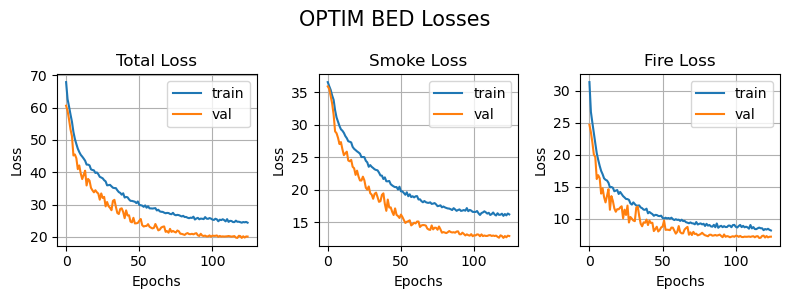

In [20]:
#plt.figure(figsize=(8,8))
fig, axs = plt.subplots(1,3, figsize=(8, 3))
fig.suptitle('OPTIM BED Losses', fontsize=15)

plt.subplot(1,3,1)
plt.plot(train_total_loss, label="train")
plt.plot(val_total_loss, label="val")
plt.title("Total Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.subplot(1,3,2)
plt.plot(train_smoke_loss, label="train")
plt.plot(val_smoke_loss, label="val")
plt.title("Smoke Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.subplot(1,3,3)
plt.plot(train_fire_loss, label="train")
plt.plot(val_fire_loss, label="val")
plt.title("Fire Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.tight_layout()
plt.savefig(log_path + "bed_losses.png")
plt.show()